In [78]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
#plt.rcParams.update({'font.size': 22})

N:  3058
Mc:  1.9903846153846152
47 47


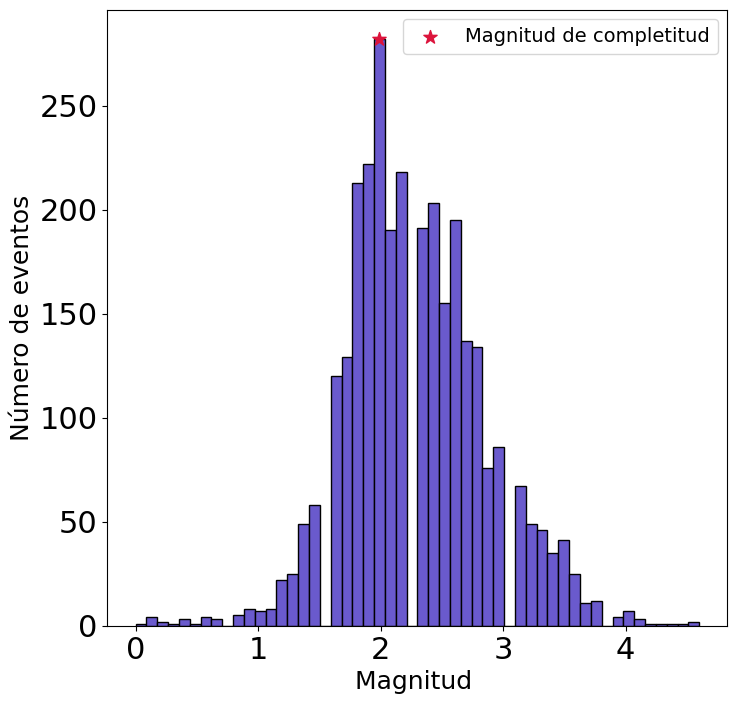

In [84]:
catalogo = 'alldets_p12.txt'
A   = pd.read_csv(catalogo, delim_whitespace=True)
A = A[A['mag'] > 0]
A = A.round({'mag':1})
values = A['mag'].value_counts().keys().tolist()
counts = A['mag'].value_counts().tolist()

mag = A['mag'].to_numpy()

print('N: ', len (mag))
A.head()

   
fig, ax = plt.subplots(figsize=(8, 8))
n_bins  = 52
#bins    = n
n, bins = np.histogram(mag, n_bins, density=False);
width   = np.diff(bins)
center  = (bins[0:-1] + bins[1:])/2 
plt.bar(center, n, width=width, color='slateblue', edgecolor='k' )
index   = np.argmax(n)
Mc      = center[index]
plt.scatter(Mc,n[index], marker='*',s = 100, color='crimson', label="Magnitud de completitud")
ax.legend(fontsize=14)
ax.set_xlabel('Magnitud ', fontsize=18)
ax.set_ylabel('Número de eventos', fontsize=18)
print('Mc: ', Mc)
print(len(values), len(counts))

## Cálculo del valor b
El **valor b** debe de ser estimado a través del método de máxima verosimilidad (**Maximum Likelihood Method**), este método fue propuesto por Aki(1965) en un artículo clásico de la sismología. La siguiente función hace el cálculo del **valor b** y su incertidumbre. Utiliza esta fución para calcular el **valor b**.

***Aki, K. (1965): Maximum likelihood estimate of b in the formula log (N) = a − bM and its confidence limits, Bull. Earthq. Res. Inst. Tokyo Univ., 43, 237-239.***

In [85]:
def valor_b(magnitudes, intervalo, Mc):
    magnitudes = magnitudes[magnitudes >= Mc]
    mag_prom   = np.mean(magnitudes)
    n          = len(magnitudes)
    
    valor_b    = (1./(mag_prom + intervalo*0.5 - Mc))*np.log10(np.exp(1))
    
    b_var      = np.var(magnitudes - mag_prom)/len(magnitudes)
    bStdDev    = 2.30*np.sqrt(b_var)*valor_b**2
    
    valor_a    = np.log10(len(mag)) + valor_b*Mc
    
    return valor_b, valor_a, bStdDev 

Valor b:  0.72  (+/-)  0.012
52 52
47 47


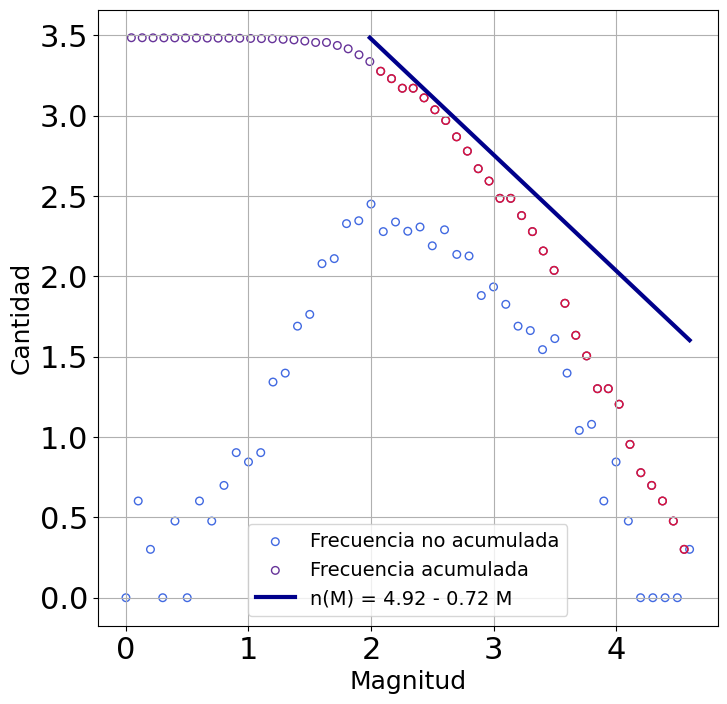

In [86]:
fig, ax    = plt.subplots(figsize=(8, 8))
Ncum       = np.cumsum(n[::-1])[::-1] 
logNcum    = np.log10(Ncum)
index_Mc   = np.where(center > center[index])
mag_Mc     = center[index_Mc]
logN_Mc    = logNcum[index_Mc]
b, a, bstd = valor_b(mag, 0.1, Mc)
logcounts = np.log10(counts)
b_mle    = (np.mean(mag_Mc)- Mc)*np.log(10)
Maux     = np.linspace(Mc, np.max(mag), 10)
Naux     = a - b*Maux

#plt.plot(center, logNcum,'^')
plt.scatter(values, logcounts, s=30, facecolors='None', edgecolors='royalblue', label='Frecuencia no acumulada')
plt.scatter(center, logNcum, s=30, facecolors='None', edgecolors='rebeccapurple', label='Frecuencia acumulada')
plt.scatter(mag_Mc, logN_Mc, s=30, facecolors='None', edgecolors='crimson')
plt.plot(Maux, Naux, color='darkblue', label = 'n(M) = ' + '%3.2f'%a + ' - %3.2f M'%b, linewidth=3)
plt.xlabel('Magnitud', fontsize=18)
plt.ylabel('Cantidad', fontsize=18)
plt.legend(fontsize=14)
plt.grid()
print('Valor b: ', '%3.2f'%b, ' (+/-) ', '%4.3f'%bstd)
print(len(center), len(logNcum))
print(len(values), len(logcounts))

### Valor esperado
```
Valor b:  1.05  (+/-)  0.005
```
![Gutenberg-Richter](./gutenberg.png)

# Ley de Omori
La **Ley de Omori** es otra ley empírica que permite modelar las réplicas que ocurren después de un sismo, de tal manera que se observa, que después de ocurrir un gran sismos la tasa de sismicidad aumenta hasta volver a sus valor ***"normal"*** de sísmicidad de fondo. Esta ley se puede escribri de la siguiente manera,<br>

$$
\begin{equation}
n(t)=\frac{K}{t+c}
\end{equation}
$$
<br>

Donde $n(t)$ es el número de réplicas por unidad de tiempo, $t$ es el tiempo medido a partir del sismos principal (**mainshock**), **K** y **c** son constantes. Estos son los pasos que hay que realizar para estimar la **Ley de Omori**.


1. Descarga el catálogo de sismos de la página del **Servicio Sismológico Nacional** <a href="www.ssn.unam.mx">www.ssn.unam.mx</a> para todos los sismos en el Golfo de Tehuantepec (establece una área de búsqueda alrededor de la ruptura principal). **Nota.** El sismo ocurrió cerca de la media noche del **7 de septiembre de 2017**, si haces la búsqueda utilizando el tiempo UTC, el sismo ocurre el **8 de septiembde del 2017**. 
2. Calcula un histograma en incremetos de 1 día. 
3. Define una función para calcular la Ley de Omori. **Nota.** Para facilitar el ajuste de los datos posteriormente, está función deberá de regresar **$log_{10}(n(t))$** en lugar del valor absoluto.
4. Notarás que existe otro sísmo que dispará de nuevo la sismicidad de fondo. Acota tus datos para valores menores a este tiempo de forma que sea más fácil acotar una curva.
5. Utiliza la función ``scipy.optimize.curve_fit`` para ajustar una curva a tus datos y calcular **$K$** y **$c$**. 
6. Grafíca tus resultados.

In [27]:
a=pd.read_csv('aftershocks.csv', delimiter=' ')
a['timestamp']=pd.to_datetime(a['fecha_hora'])
a['dt']=(a['timestamp'] - a['timestamp'][0]).dt.total_seconds()
a.head(10)
print('tmax: ', a['dt'].max(), ' log10(tmax): ', np.log10(a['dt'].max()))

tmax:  105857332.0  log10(tmax):  8.02472094395074


C:\Users\jazminnhalaura\AppData\Local\Temp\ipykernel_30516\4026145525.py:9: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  n[int(day)]    = data_series.between(day*86400, (day + 1)*86400, inclusive=True).sum()


cbin:  (316,)
min:  1.3082521416533108


C:\Users\jazminnhalaura\AppData\Local\Temp\ipykernel_30516\4026145525.py:14: RuntimeWarning: invalid value encountered in log10
  OmoriLaw    = lambda t, k, c: np.log10(k/(t+c))


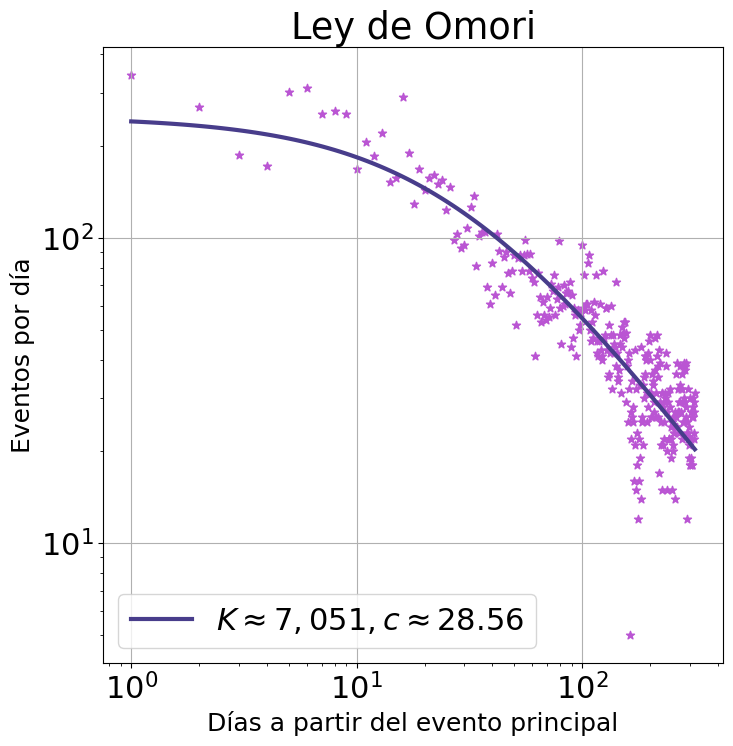

In [35]:
def log_histogram(data_series):
    #bin_log = np.logspace(0, np.log10(data_series['dat'], Nbins_log))
    
    ndays = np.round(data_series.max()/86400)
    n     = np.zeros((int(ndays),1))
    cbin  = np.zeros((int(ndays),1))
    n[0]
    for day in np.arange(0, ndays):
        n[int(day)]    = data_series.between(day*86400, (day + 1)*86400, inclusive=True).sum()
        cbin[int(day)] = day + 1
    return n, cbin

tmax        = 10**2.5
OmoriLaw    = lambda t, k, c: np.log10(k/(t+c)) 

n_log, cbin = log_histogram(a['dt'])

index_lim   = np.where(cbin <= tmax)
cbin        = cbin[index_lim]
n_log       = n_log[index_lim]

t_aux       = np.logspace(0,2.5,101)
print('cbin: ',cbin.flatten().shape)
popt, pcov  = curve_fit(OmoriLaw, cbin.flatten(), np.log10(n_log.flatten()))

n_aux       = OmoriLaw(t_aux, 7000, 28)


fig, ax = plt.subplots(figsize=(8, 8))
#plt.loglog(cbin, n_log, marker='*', color='blueviolet')
plt.scatter(cbin, n_log, marker='*', color='mediumorchid')
print("min: ",np.min(n_aux))
ax.set_xscale("log", base=10)
ax.set_yscale("log", base=10)
plt.loglog(t_aux, np.power(10, n_aux),color = 'darkslateblue',linewidth=3, label=r"$K\approx7,051, c\approx 28.56$")
plt.legend()
plt.xlabel('Días a partir del evento principal', fontsize=18)
plt.ylabel('Eventos por día', fontsize=18)
#plt.title('Sismo de Tehuantepec, M8.2, 2017')
plt.title('Ley de Omori')
#plt.plot('Aftershocks')
plt.grid()

![Ley de Omori](./omori.png)
